In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from matplotlib import cm
import sympy as spy
import sympy.abc as abc
import joblib

from sklearn.preprocessing import MinMaxScaler
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error
import sklearn.preprocessing
from tqdm import tqdm

from src.mlhgp import MLHGP
from src.imlhgp import IMLHGP
from src.nnpehgp import NNPEHGP
from src.kshgp import KSHGP
from src.ksmlhgp import KSMLHGP
from src.ksimlhgp import KSIMLHGP
from src.rnmlhgp import RNHGP as RNHGP2
from src.rnimlhgp import RNHGP as RNHGP3
from src import evaluator

## SUPPRESS ALL WARNINGS
import warnings
warnings.filterwarnings("ignore")

import scienceplots

plt.style.use('science')

In [2]:
params = {'xtick.labelsize':12,
          'ytick.labelsize':12,
          'axes.labelsize': 16,
          'axes.titlesize': 18}
plt.rcParams.update(params)

# Problem Definition

Temperature of solid sphere immersed in fluid under uncertainty. Described as:

$$
Y = u_2 + u_3 \sum_{i=1}^\infty \frac{4(\sin\eta_i - \eta_i \cos \eta_i)}{2\eta_i - \sin(2\eta_i)} \exp(-\eta_i^2 \pi_2) \frac{\sin(\eta_i u_1)}{\eta_i u_1},
$$

where $\eta_i$ is a solution of:

$$
1 - \eta_i \cot \eta_i = \pi_1, \quad \eta_i \in ((i-1)\pi, i\pi),
$$

where:

$$
\pi_1 = \frac{u_4 u_7}{u_6}, \quad \pi_2 = \frac{u_6 u_5}{u_8 u_9 u_7^2}
$$

>NOTE: We can approximate the infinite sum with the **first four terms** only

Input variable definition:

| Variable | Description                          | Units          | Minimum | Maximum |
|----------|--------------------------------------|----------------|---------|---------|
| $u_1$      | Distance from the center of sphere   | -              | 0       | 1       |
| $u_2$      | Temperature of fluid                 | $K$              | 250     | 270     |
| $u_3$      | Initial sphere temperature           | $K$              | -100    | -30     |
| $u_4$      | Convective heat transfer coefficient | $kgs^{-3}K^{-1}$ | 180     | 210     |

Fixed / random variables definition

| Variable | Description          | Units               | Value/Distribution         |
|----------|----------------------|---------------------|----------------------------|
| $u_5$    | Time                 | $s$                 | 800                        |
| $u_6$    | Thermal conductivity | $kgs^{-3}K^{-1}$    | $\mathcal{N}(65, 10.3^2)$    |
| $u_7$    | Sphere's radius      | $m$                 | $\mathcal{N}(0.1, 0.02^2)$   |
| $u_8$    | Specific heat        | $m^2 s^{-2} K^{-1}$ | $\mathcal{N}(400, 33.3^2)$   |
| $u_9$    | Density              | $kgm^{-3}$          | $\mathcal{N}(8000, 333.3^2)$ |

In [3]:
def pi1(u4, u6, u7):
    return (u4*u7)/u6

def pi2(u5, u6, u7, u8, u9):
    return (u5*u6) / (u8*u9*(u7**2))

In [4]:
def eta_i_fun(pi_1, i):
    lower_limit = (i-1)*np.pi
    upper_limit = i*np.pi
    solnrange = np.linspace(lower_limit, upper_limit, num=5)
    solutions = []

    for x0 in solnrange:
        try:  # Sometimes 0 division error happen when the initial x0 is not right, using try except to bypass the error
            solutions.append(spy.nsolve(1 - pi_1 - (abc.x * spy.cot(abc.x)) , x0))
        except:
            pass

    solutions = np.unique(solutions)
    cond1 = solutions >= lower_limit
    cond2 = solutions <= upper_limit
    solutions = solutions[np.where(cond1 & cond2)]
    if len(solutions) != 1:
        print(f"eta_i solution is not unique, solution: {solutions}, proceed with taking the first solution")
    
    return solutions[0]

In [5]:
def solve_function(u):
    assert len(u) == 9, "Input length must be 9 (There are 9 input variables)"

    pi_1 = pi1(u[3], u[5], u[6])
    pi_2 = pi2(u[4], u[5], u[6], u[7], u[8])

    # Compute summation, approximating by first four terms:
    temp_res = []
    for i in range(1,5):  # i = [1,2,3,4]
        # Compute eta_i
        eta_i = float(eta_i_fun(pi_1, i))  # convert sympy solution to float, otherwise it's not compatible with numpy
        first_term = (4 * (np.sin(eta_i) - (eta_i * np.cos(eta_i)))) / ((2*eta_i) - np.sin(2*eta_i))
        second_term = np.exp(-1 * eta_i**2 * pi_2) * ((np.sin(eta_i*u[0])) / (eta_i*u[0]))
        temp_res.append(first_term * second_term)
    summation = np.sum(temp_res)

    y = u[1] + u[2]*summation

    return y
        

## Testing samples

In [6]:
n_test = 1000  # Number of testing points
n_realization = 10000  # Number of realization for each testing point, to obtain distribution

x_test = joblib.load("data/sphere_heat_test.pkl") #just load the x_test input data
rand_input = joblib.load("data/sphere_randinput_test.pkl") #just load the x_test input data
y_test = joblib.load("output/sphere_result_all.pkl") # load the response data

### Train data

In [7]:
def train_data_maker(seednum, samp_size=160):
    np.random.seed(seednum)
    n_train = samp_size
    x_train = np.random.uniform(low=[0,250,-100,180], high=[1,270,-30,210], size=(n_train,4))
    u5 = np.tile(800, (int(n_train),1))  # time variable
    u6 = np.random.normal(loc = 65, scale=10.3, size=(n_train,1))  # thermal conductivity
    u7 = np.random.normal(loc = 0.1, scale=0.02, size=(n_train,1))  # Sphere's radius
    u8 = np.random.normal(loc = 400, scale=33.3, size=(n_train,1))  # Specific heat
    u9 = np.random.normal(loc = 8000, scale=333.3, size=(n_train,1))  # Sphere's density
    rand_input = np.hstack((u5,u6,u7,u8,u9))
    eval_input = np.hstack((x_train, rand_input))

    # Evaluate training data
    y_train = []
    for inp in eval_input:
        y_train.append(solve_function(inp))
    
    y_train = np.array(y_train).reshape(-1,1)

    return [x_train, y_train]

### Try One Pass

In [8]:
x_train, y_train = train_data_maker(42, 160)

### Normalize input feature

In [9]:
# Normalize X
normalizer = sklearn.preprocessing.StandardScaler().fit(x_train)
x_train_norm =  normalizer.transform(x_train)
x_test_norm =  normalizer.transform(x_test)

In [10]:
x_train_norm

array([[-3.69355381e-01,  1.55524214e+00,  8.22090673e-01,
         2.88787132e-01],
       [-1.07951082e+00, -1.18414549e+00, -1.44878975e+00,
         1.20875426e+00],
       [ 3.66972204e-01,  7.18859603e-01, -1.57515080e+00,
         1.56548435e+00],
       [ 1.11874533e+00, -9.89926502e-01, -1.03181763e+00,
        -1.13923076e+00],
       [-5.97810814e-01,  8.69714931e-02, -1.88986315e-01,
        -7.68432378e-01],
       [ 4.01868389e-01, -1.24102303e+00, -6.60072616e-01,
        -5.10058345e-01],
       [-1.04398006e-01,  9.84633853e-01, -9.71672352e-01,
        -1.53892200e-03],
       [ 3.38697332e-01, -1.56174245e+00,  4.02733691e-01,
        -1.18352515e+00],
       [-1.37513734e+00,  1.54893840e+00,  1.60938261e+00,
         1.01005862e+00],
       [-5.96603421e-01, -1.38518198e+00,  6.61150378e-01,
        -2.56299500e-01],
       [-1.18994102e+00, -1.49886906e-02, -1.52863527e+00,
         1.35712315e+00],
       [-7.45554974e-01,  5.61848399e-01, -5.94139486e-01,
      

## Define Models


In [11]:
# define the model
def hgp_constructor(X_train_norm, y_train, kernel, kernel_noise):
    hgps = [MLHGP,IMLHGP,NNPEHGP,KSMLHGP,KSIMLHGP]
    trained_hgps = []

    for hgp in hgps:
        # Initialize models
        gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=25)
        gp_noise = GaussianProcessRegressor(kernel=kernel_noise, n_restarts_optimizer=25)
        model_hgp = hgp(model=gp, model_noise=gp_noise)

        # fit the model
        model_hgp.fit(X_train_norm, y_train.flatten())
        trained_hgps.append(model_hgp)

    return trained_hgps

In [12]:
init_lengthscale = tuple([1]*4)
lenscale_bounds = tuple([(1e-2,1e2)]*4)

kernel = ConstantKernel(1.0) * RBF(length_scale=init_lengthscale, length_scale_bounds=lenscale_bounds) + WhiteKernel(
        noise_level=1, noise_level_bounds=(1e-4, 5e-1)
    )
kernel_noise = ConstantKernel(1.0) * RBF(length_scale=init_lengthscale, length_scale_bounds=lenscale_bounds) + WhiteKernel(
    noise_level=1, noise_level_bounds=(1e-4, 8e-2)
    )
hgp = hgp_constructor(x_train_norm, y_train, kernel, kernel_noise)

In [13]:
# make a prediction 
model_name = ["MLHGP", "IMLHGP", "NNPEHGP", "KSMLHGP", "KSIMLHGP"]
res_dict = {}
for idx,hgp_model in tqdm(enumerate(hgp)):
    subres_dict = {}
    Y_pred, Std_pred = hgp_model.predict(x_test_norm, return_std="multi")
    subres_dict["y_pred"] = Y_pred
    subres_dict["std_pred"] = Std_pred
    res_dict[model_name[idx]] = subres_dict

0it [00:00, ?it/s]

5it [00:00, 13.41it/s]


### Quantitative Evaluation

In [14]:
def score_eval(X_test, y_test_mean, y_test_std, y_pred, std_al, std_ep):

    # Compute average Wasserstein distance (Earth moving distance)
    d_wass_list = []
    for i,x in enumerate(X_test):
        # actual distribution
        act_dist = [y_test_mean[i,:], y_test_std[i,:]]
        pred_dist = [y_pred[i], std_al[i]]

        d_wass, dists, m2 = evaluator.wasserstein2(act_dist, pred_dist)
        d_wass_list.append(d_wass)
    
    avg_wass = np.mean(d_wass_list)

    # Compute SMSE of noise
    smse = evaluator.noise_smse(std_al, y_test_std)

    # Compute NLPD
    std_tot = np.sqrt(std_al**2 + std_ep**2)
    nlpd = evaluator.nlpd_loss(y_test_mean, y_pred, std_tot**2)

    return avg_wass, smse, nlpd

In [15]:
for name in model_name:
    res = res_dict[name]
    y_pred = res["y_pred"]
    std_al, std_ep = res["std_pred"]
    avg_wass, smse, nlpd = score_eval(x_test_norm, y_test[:,0].reshape(-1,1), y_test[:,1].reshape(-1,1), y_pred, std_al, std_ep)
    print(name)
    print(f"Average Wasserstein: {avg_wass}, Noise SMSE: {smse}, NLPD: {nlpd}")

MLHGP
Average Wasserstein: 112.22740580841675, Noise SMSE: 6.113221145674394, NLPD: 1.75883961583406
IMLHGP
Average Wasserstein: 195.4372876957261, Noise SMSE: 10.378799264183767, NLPD: 2.6400607531463005
NNPEHGP
Average Wasserstein: 164.06072604322748, Noise SMSE: 10.15845225615299, NLPD: 2.1661001764367986
KSMLHGP
Average Wasserstein: 97.08468973054369, Noise SMSE: 5.488888395031382, NLPD: 1.6394661737566598
KSIMLHGP
Average Wasserstein: 230.51906121537303, Noise SMSE: 10.230757353598037, NLPD: 2.7981060870268277


In [16]:
for name,gp in zip(model_name,hgp):
    print(name)
    print(f"Kernel mean: {gp.model.kernel_}")
    try:
        print(f"Kernel noise: {gp.model_noise.kernel_}")
    except:
        pass

MLHGP
Kernel mean: 146**2 * RBF(length_scale=[4.49, 0.252, 3.56, 27.7]) + WhiteKernel(noise_level=0.5)
Kernel noise: 0.772**2 * RBF(length_scale=[10.3, 39, 100, 14.3]) + WhiteKernel(noise_level=0.08)
IMLHGP
Kernel mean: 148**2 * RBF(length_scale=[4.39, 0.246, 4.32, 4.77])
Kernel noise: 0.101**2 * RBF(length_scale=[0.355, 0.808, 100, 0.305]) + WhiteKernel(noise_level=0.000491)
NNPEHGP
Kernel mean: 132**2 * RBF(length_scale=[2.75, 0.9, 11.5, 0.569])
Kernel noise: 0.0236**2 * RBF(length_scale=[2.27, 2.47, 3.94, 2.73]) + WhiteKernel(noise_level=0.0001)
KSMLHGP
Kernel mean: 146**2 * RBF(length_scale=[4.94, 0.257, 3.8, 28.1]) + WhiteKernel(noise_level=0.5)
KSIMLHGP
Kernel mean: 148**2 * RBF(length_scale=[4.39, 0.246, 4.32, 4.77])


## Varying Random Seeds

In [17]:
def main(datasize, repeat=100):

    model_name = ["MLHGP", "IMLHGP", "NNPEHGP", "KSMLHGP", "KSIMLHGP"]
    metrics_name = ["wasserstein", "smse", "nlpd", "model"]

    ## Initialize metrics dictionary
    model_scores = dict()
    for met in metrics_name:
        model_scores[met] = dict()
        for name in model_name:
            model_scores[met][name] = []
    
    model_scores["train_data"] = []

    for i in tqdm(range(repeat)):
        X_train, y_train = train_data_maker(seednum=i, samp_size=datasize)
        train = {"x": X_train, "y": y_train}
        model_scores["train_data"].append(train)

        # Compute loc and scale as functions of input X
        x_test = joblib.load("data/sphere_heat_test.pkl") #just load the x_test input data
        y_test = joblib.load("output/sphere_result_all.pkl") # load the response data
        y_test_mean = y_test[:,0].reshape(-1,1)
        y_test_std = y_test[:,1].reshape(-1,1)

        # Sample outputs Y from Gaussian Likelihood
        np.random.seed(42)
        y_test = np.random.normal(y_test_mean, y_test_std)
        
        # Normalize X
        normalizer = sklearn.preprocessing.StandardScaler().fit(x_train)
        x_train_norm =  normalizer.transform(X_train)
        x_test_norm =  normalizer.transform(x_test)

        # Train models
        init_lengthscale = tuple([1]*4)
        lenscale_bounds = tuple([(1e-2,1e2)]*4)

        kernel = ConstantKernel(1.0) * RBF(length_scale=init_lengthscale, length_scale_bounds=lenscale_bounds) + WhiteKernel(
                noise_level=1, noise_level_bounds=(1e-4, 5e-1)
            )
        kernel_noise = ConstantKernel(1.0) * RBF(length_scale=init_lengthscale, length_scale_bounds=lenscale_bounds) + WhiteKernel(
            noise_level=1, noise_level_bounds=(1e-4, 8e-2)
            )
        hgp = hgp_constructor(x_train_norm, y_train, kernel, kernel_noise)

        # make a prediction
        res_dict = {}
        for idx,hgp_model in enumerate(hgp):
            subres_dict = {}
            Y_pred, Std_pred = hgp_model.predict(x_test_norm, return_std="multi")
            subres_dict["y_pred"] = Y_pred
            subres_dict["std_pred"] = Std_pred
            res_dict[model_name[idx]] = subres_dict
            model_scores["model"][model_name[idx]].append(hgp_model)
        
        # Evaluate
        for name in model_name:
            res = res_dict[name]
            y_pred = res["y_pred"]
            std_al, std_ep = res["std_pred"]
            avg_wass, smse, nlpd = score_eval(x_test_norm, y_test_mean, y_test_std, y_pred, std_al, std_ep)
            model_scores["wasserstein"][name].append(avg_wass)
            model_scores["smse"][name].append(smse)
            model_scores["nlpd"][name].append(nlpd)
        
    return model_scores

In [18]:
model_scores = main(datasize=160, repeat=25)

100%|██████████| 25/25 [41:59<00:00, 100.79s/it]


In [22]:
params = {'xtick.labelsize':14,
          'ytick.labelsize':14,
          'axes.labelsize': 20,
          'axes.titlesize': 22}
plt.rcParams.update(params)

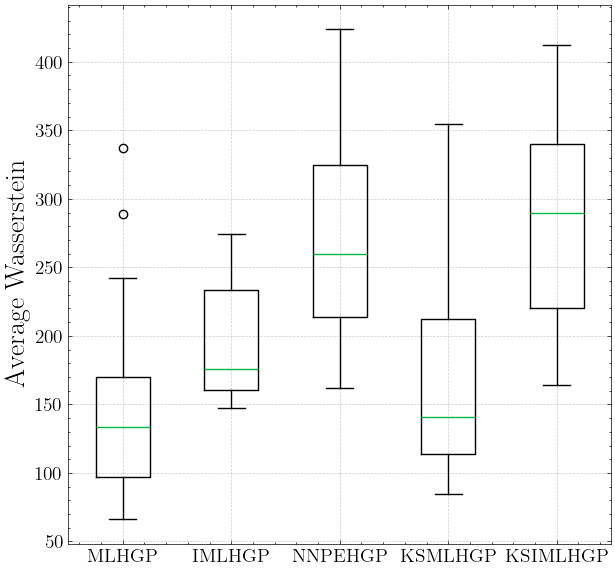

In [23]:
fig, ax = plt.subplots(figsize=(7,7))
ax.boxplot(model_scores["wasserstein"].values())
ax.set_xticklabels(model_scores["wasserstein"].keys())
ax.set_ylabel("Average Wasserstein")
plt.grid(True, color="0.8", linestyle='--')
plt.savefig("img/heat_4d/average_wasserstein.pdf", dpi=300, format="pdf")
plt.show()

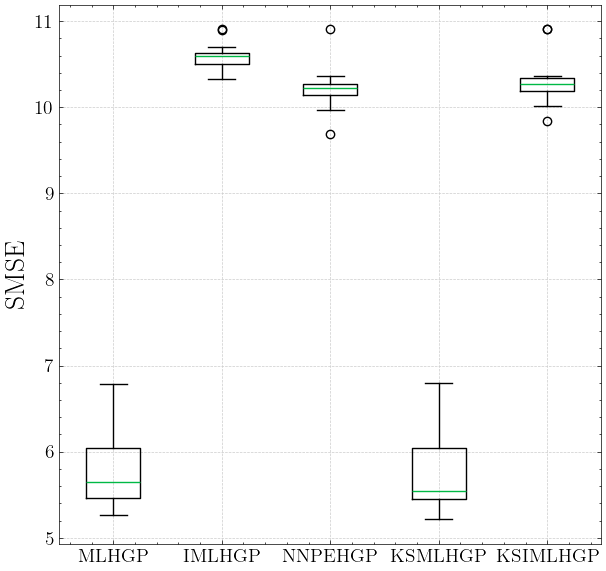

In [24]:
fig, ax = plt.subplots(figsize=(7,7))
ax.boxplot(model_scores["smse"].values())
ax.set_xticklabels(model_scores["wasserstein"].keys())
ax.set_ylabel("SMSE")
plt.grid(True, color="0.8", linestyle='--')
plt.savefig("img/heat_4d/smse.pdf", dpi=300, format="pdf")
plt.show()

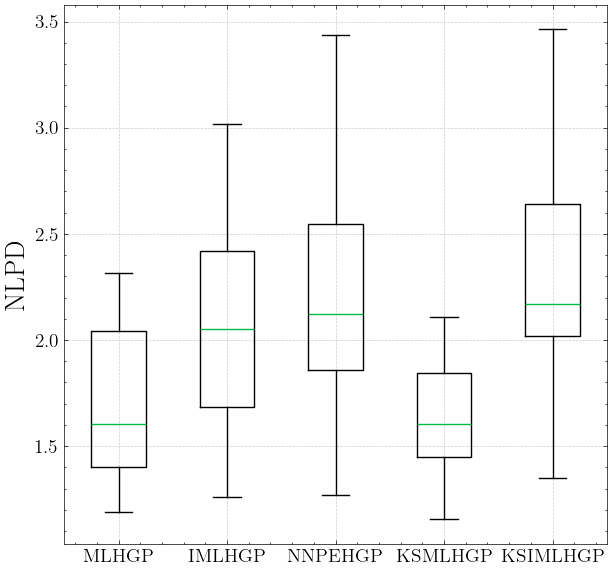

In [25]:
fig, ax = plt.subplots(figsize=(7,7))
ax.boxplot(model_scores["nlpd"].values())
ax.set_xticklabels(model_scores["wasserstein"].keys())
# ax.set_ylim(0,8)
ax.set_ylabel("NLPD")
plt.grid(True, color="0.8", linestyle='--')
plt.savefig("img/heat_4d/nlpd.pdf", dpi=300, format="pdf")
plt.show()